<a href="https://colab.research.google.com/github/zolfaShefreie/Sentiment-Analysis-of-SnappFood-Comments/blob/main/model_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


#install packages

In [2]:
!pip install parsivar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.2 MB 258 kB/s 
     |████████████████████████████████| 1.5 MB 38.8 MB/s 
  Created wheel for parsivar: filename=parsivar-0.2.3-py3-none-any.whl size=36492972 sha256=b525db04fd98439e0afd660b894e97fd68e29e53b36a7f917092282d83c2e8e9
  Stored in directory: /root/.cache/pip/wheels/ae/67/7a/49cbf08f64d3f76a26eceaf0e481a40e233f05d4356875cbed
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449923 sha256=472d55e66354a10f1085c7dcd8346f240664dba6fbcce6ffcd95526df9261bd5
  Stored in directory: /root/.cache/pip/wheels/48/8b/7f/473521e0c731c6566d631b281f323842bbda9bd819eb9a3ead
Successfully built parsivar nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [3]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 39.3 MB/s 
     |████████████████████████████████| 233 kB 60.2 MB/s 
     |████████████████████████████████| 1.4 MB 45.3 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394487 sha256=1eed695a8a1bc3a942f777bc705523e01f1cb06d10eff11912afc227e2841c0f
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154166 sha256=45bbb722a0a0ef127067c657c80ffcdc862c59e6da24b1d8c2b8a7c5814e57d0
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.4.5
    Uninstalling nltk-3.4.5:
      Successfully uninstalled nltk-3.4.5
ERROR: pip's dependen

In [4]:
!pip install googletrans==4.0.0-rc1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 1.3 MB 64.1 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 65 kB 4.4 MB/s 
     |████████████████████████████████| 53 kB 2.8 MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17416 sha256=d4de2466667c86519b37b93ec8dd503119ef43d5191e1cb22adaec98786b9b18
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans


In [5]:
!pip install finglish

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 27.5 MB/s 


In [6]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 26.8 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=03941c4ab4f58706b245edc7362612f3dfc0c6abcbb80e9bf3ff1d7b836fcf6c
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


#imports

In [7]:
from googletrans import Translator
import parsivar
from finglish import f2p
import hazm
import requests
import io
from textblob import Word
import os
from langdetect import detect

Loading converters...
Loading persian word list...
Loading dictionary...


In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalMaxPooling1D, Flatten
from tensorflow.keras import Model
import keras

In [10]:
tf.__version__, keras.__version__

('2.8.2', '2.8.0')

#utility

In [11]:
def get_stopwords():
  url = "https://raw.githubusercontent.com/zolfaShefreie/Sentiment-Analysis-of-SnappFood-Comments/main/persian_stopword"
  content = requests.get(url).content.decode("utf-8") 
  return set([w for w in content.split('\n') if w])


In [12]:
class TextCleaner:
    punc = '''!()-[]{.};:'"\,<>/?@#$%^&*_~`|’“”…—–'''
    normalizer = parsivar.Normalizer(date_normalizing_needed=True, 
                                     statistical_space_correction=True)
    stemmer = parsivar.FindStems()
    lemmatizer = hazm.Lemmatizer()
    tokenizer = parsivar.Tokenizer()
    translator = Translator()
    stopwords = get_stopwords()

    @classmethod
    def normalize(cls, text):
        """
        convert to persian and normlize the text
        """
        if detect(text) == "en":
            text = cls.translator.translate(text, src="en", dest="fa").text
        elif detect(text) != "fa":
            text = f2p(text)
        text = cls.normalizer.normalize(text)
        return text
    
    @classmethod
    def remove_punc(cls, text):
        for each in cls.punc:
            text = text.replace(each, ' ')
        return text
    
    @classmethod
    def stem_lemmet_word(cls, word):
        """
        apply stem and lemmet on word
        """
        new_word = word.strip()
        new_word = cls.stemmer.convert_to_stem(new_word)
        if '&' in new_word:
            new_word = new_word.split('&')[0]
        new_word = cls.lemmatizer.lemmatize(new_word)
        if '#' in new_word:
            new_word = new_word.split('#')[0]
        return new_word
        

    @classmethod
    def word_cleaning(cls, text, use_stemm=True, use_lemmet=True, 
                      remove_stopword=True):
      tokens = cls.tokenizer.tokenize_words(text)
      new_text = str()
      for token in tokens:
          if use_stemm:
              token = cls.stemmer.convert_to_stem(token)
              if '&' in token:
                  token = token.split('&')[0]
          if use_lemmet:
              token = cls.lemmatizer.lemmatize(token)
              if '#' in token:
                  token = token.split('#')[0]
          if remove_stopword and token in cls.stopwords:
              continue
          new_text += " " + token
      return new_text
    
    @classmethod
    def clean_text(cls, text, use_stemm=False, use_lemmet=False, 
                   remove_stopword=False):

        text = cls.normalize(text)
        text = cls.remove_punc(text)
        text = cls.word_cleaning(text, use_stemm, use_lemmet, remove_stopword)
        text = text.replace('‌', ' ')
        text = " ".join(text.split())
        return text


In [13]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [14]:
def get_embedding_matrix(word_index, embedding_index, embed_dim, check_word_clean=True):
    """
    create matrix besed on word_index
    """
    embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
    miss_word = set()
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word, None)
        if embedding_vector is None:
            embedding_vector = embedding_index.get(TextCleaner.stem_lemmet_word(word), None)
        if embedding_vector is not None:
            try:
                embedding_matrix[i] = np.fromiter(embedding_vector, dtype='float32')
            except:
                pass
        else:
            miss_word.add(word)
    return embedding_matrix, miss_word

#load dataset

In [15]:
train_file_path = "/content/drive/MyDrive/snappfood_comment/train.csv"
validation_file_path = "/content/drive/MyDrive/snappfood_comment/dev.csv"
need_clean_train = False
need_cleean_validation = False
if not os.path.exists(train_file_path):
    train_file_path = "/content/drive/MyDrive/DM/train.csv"
    need_clean_train = True
if not os.path.exists(validation_file_path):
    validation_file_path = "/content/drive/MyDrive/DM/dev.csv"
    need_cleean_validation = True

In [16]:
train_df = pd.read_csv(train_file_path, delimiter='\t' if need_clean_train else None , index_col=0)
validation_df = pd.read_csv(validation_file_path, delimiter='\t' if need_clean_train else None, index_col=0)

In [17]:
if need_clean_train:
    train_df['clean_comment'] = train_df['comment'].apply(TextCleaner.clean_text)
    train_df.to_csv("/content/drive/MyDrive/snappfood_comment/train.csv")

In [18]:
if need_cleean_validation:
    validation_df['clean_comment'] = validation_df['comment'].apply(TextCleaner.clean_text)
    validation_df.to_csv("/content/drive/MyDrive/snappfood_comment/dev.csv")

In [19]:
train_df

,comment,label,label_id,clean_comment
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0,قرار بود 1 ساعته برسه ولی نیم ساعت زودتر از مو...
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1,قیمت این مدل اصلا با کیفیتش سازگاری نداره ، فق...
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0,عالللی بود همه چه درست و به اندازه و کیفیت خوب...
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0,شیرینی وانیلی فقط 1 مدل بود
...,...,...,...,...
56695,یک تیکه کم فرستاده بودن و با تماس من در کمترین...,HAPPY,0,1 تیکه کم فرستاده بودن و با تماس من در کمترین ...
56696,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...,HAPPY,0,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...
56697,مثل همیشه عالی، من چندمین باره سفارش میدم و هر...,HAPPY,0,مثل همیشه عالی ، من چندمین باره سفارش میدم و ه...
56698,دلستر استوایی خواسته بودم اما لیمویی فرستادند,HAPPY,0,دلستر استوایی خواسته بودم اما لیمویی فرستادند


In [20]:
validation_df

,comment,label,label_id,clean_comment
0,همه ساندویچ‌ها سرد بود متاسفانه در صورتی که فا...,SAD,1,همه ساندویچ ها سرد بود متاسفانه در صورتی که فا...
1,تشکر، عالی‌تر از همیشه,HAPPY,0,تشکر ، عالی تر از همیشه
2,مرغ و کدو رو دوس نداشتم ولی کلا ساندویچهای خوش...,HAPPY,0,مرغ و کدو رو دوس نداشتم ولی کلا ساندویچهای خوش...
3,نمیدونم هزینه بسته بندی به چه دلیل گرفته شد؟؟؟,SAD,1,نمیدونم هزینه بسته بندی به چه دلیل گرفته شد ؟؟؟
4,یک نوشابه کم ارسال شد و تاخیر فراوان و غذای نس...,SAD,1,1 نوشابه کم ارسال شد و تاخیر فراوان و غذای نسب...
...,...,...,...,...
6295,سلام من به فاکتور غذاهایی که سفارش میدم احتیاج...,SAD,1,سلام من به فاکتور غذاهایی که سفارش میدم احتیاج...
6296,سایز پیتزا نسبت به سفارشاتی که قبلا گذشتم کم ش...,SAD,1,سایز پیتزا نسبت به سفارشاتی که قبلا گذشتم کم ش...
6297,من قارچ اضافه رو اضافه کرده بودم بودم اما اگر ...,HAPPY,0,من قارچ اضافه رو اضافه کرده بودم بودم اما اگر ...
6298,همرو بعد ۲ساعت تاخیر اشتباه آوردن پولشم رفت رو...,SAD,1,همرو بعد 2ساعت تاخیر اشتباه آوردن پولشم رفت رو...


#tokenizer

In [21]:
tokenizer = Tokenizer(20000)
#fit based on validation and train dataset
tokenizer.fit_on_texts(train_df.clean_comment)

In [22]:
word_index = tokenizer.word_index
len(word_index)

25399

In [23]:
train_sequences = tokenizer.texts_to_sequences(train_df.clean_comment)
validation_sequences = tokenizer.texts_to_sequences(validation_df.clean_comment)
# max_len = len(max(train_sequences + validation_sequences, key=len))
max_len = 128
train_data = pad_sequences(train_sequences, maxlen=max_len)
validation_data = pad_sequences(validation_sequences, maxlen=max_len)

#pre-trained embed weights

In [24]:
!wget http://vectors.nlpl.eu/repository/20/61.zip

--2022-06-25 16:39:08--  http://vectors.nlpl.eu/repository/20/61.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 730416332 (697M) [application/zip]
Saving to: ‘61.zip’

61.zip              100%[===================>] 696.58M  11.5MB/s    in 69s     

2022-06-25 16:40:17 (10.2 MB/s) - ‘61.zip’ saved [730416332/730416332]



In [25]:
!unzip /content/61.zip

Archive:  /content/61.zip
  inflating: LIST                    
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


In [26]:
vector_embed_file = "/content/model.txt"
embed_dim = 100

In [27]:
embeddings_index = load_vectors(vector_embed_file)
len(embeddings_index)

966446

In [28]:
embedding_matrix, miss_word = get_embedding_matrix(word_index, embeddings_index, embed_dim)
del embeddings_index
print(len(miss_word))

5592


In [29]:
print(miss_word)

{'snappfood', 'بگذزارند', 'بسیارررررررر', 'یخزدش', 'متاسفانه200گرم', 'مشتریهاتونو', 'عاااللی', 'بوددددددددددددددددددددددددددددددددددددددددددددددد', '400لیتری', 'خششششک', 'چلوبرگ', 'بیکیفیته', 'بیشتربپذه', 'العاااااده', 'y0m8d1', 'وتشکروسپاس', 'ازپیکهابسباربی', 'marinade', 'خودده', 'مزههههه', 'سڀاس', 'چقدرررررر', 'یزدیشو', 'indaf', 'فرچیز', 'نسبتاپایین', 'بهذغذای', 'سزخ', 'فودسرعت', '5هزارتومنم', 'اذیذ', 'اصلانبود', '2٥00', 'ازسالم', 'دهرید', 'برمیگردنن', 'انتقادشو', 'لینوشیرین', 'بدتربن', 'بیشترخواهدبود', 'رسیدتولد', 'تحویلاتون', 'دیزاینشم', 'تحپیل', '2خوراک', 'استیکره', 'آنلاینتون', 'چایز', 'آشپزتون', 'کاکایوییش', 'دایمه', 'اوست', 'سشش', 'سفیییددد', 'گوشنش', 'پاروژ', 'موزهال', 'نخوردمش', 'غذابود', 'ولذیذبود', 'شویدش', 'استخوانتون', 'کترینگها', 'میدادمن', 'انتخابهامه', 'رسوندش', 'میعرزید', 'زحماتتوون', 'ذهنیتمون', 'نظیررررررر', 'روفرستادین', 'کروناستیزی', 'باقالاقاتق', 'بودطعم', 'سنپع', 'وسایلایی', 'پنید', 'خوبدپخته', 'ماانداختیم', 'پیتزا500', 'میکسیه', 'لصلا', 'آلبنی', 'بالاتربره', 'ا

#Compare lstm and cnn

##Model using cnn

###get model

In [46]:

def get_model_cnn(embedding_matrix, word_index_len, embed_dim, max_len, save_model_path):
    """
    load model if exists else create a model and return compiled model
    """
    if os.path.exists(save_model_path):
        model = tf.keras.models.load_model(save_model_path)
        return model, False
    
    else:
      input_layer = Input(shape=(max_len,), dtype='int32')
      embedding_layer = Embedding(word_index_len + 1,
                                  embed_dim,
                                  weights=[embedding_matrix],
                                  input_length=max_len,
                                  trainable=True, 
                                  mask_zero=True)
      embedded_sequences = embedding_layer(input_layer)
      x = Conv1D(128, 3, activation='relu')(embedded_sequences)
      x = MaxPooling1D(2)(x)
      x = Flatten()(x)
      x = Dropout(0.5)(x)
      x = Dense(32, activation='relu')(x)
      preds = Dense(1, activation='sigmoid')(x)

      model = Model(input_layer, preds)
      model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=['accuracy'])
      return model, True

In [47]:
save_model_path = "/content/drive/MyDrive/snappfood_comment/cnn_model.h5"
model, need_train = get_model_cnn(embedding_matrix, len(word_index), embed_dim, max_len, save_model_path)

In [48]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 128, 100)          2540000   
                                                                 
 conv1d_6 (Conv1D)           (None, 126, 128)          38528     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 63, 128)          0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 8064)              0         
                                                                 
 dropout_3 (Dropout)         (None, 8064)              0         
                                                           

###train model

In [49]:
if need_train:
    history = model.fit(train_data, train_df.label_id, epochs=5, 
                        validation_data=(validation_data, validation_df.label_id),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=1)])
    model.save(save_model_path)

Epoch 1/5
1772/1772 [==============================] - 102s 57ms/step - loss: 0.3744 - accuracy: 0.8370 - val_loss: 0.3306 - val_accuracy: 0.8654
Epoch 2/5
1772/1772 [==============================] - 97s 55ms/step - loss: 0.3104 - accuracy: 0.8717 - val_loss: 0.3267 - val_accuracy: 0.8643
Epoch 3/5
1772/1772 [==============================] - 97s 55ms/step - loss: 0.2775 - accuracy: 0.8868 - val_loss: 0.3370 - val_accuracy: 0.8592


####train plot

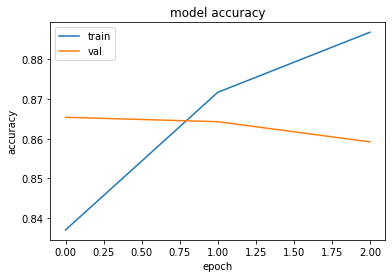

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

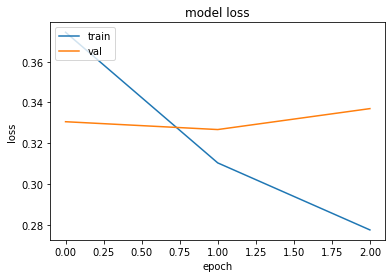

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###evaluate model

In [52]:
test_path = "/content/drive/MyDrive/DM/dev.csv"

In [53]:
test_df = pd.read_csv(test_path, delimiter='\t' , index_col=0)
test_df['clean_comment'] = test_df['comment'].apply(TextCleaner.clean_text)
test_sequences = tokenizer.texts_to_sequences(test_df.clean_comment)
test_data = pad_sequences(test_sequences, maxlen=max_len)

error
error


In [54]:
y_pred = model.predict(test_data)

In [55]:
y_pred.shape

(6300, 1)

In [56]:
y_pred = np.array(y_pred > 0.5).astype("int32")

In [57]:
print(classification_report(test_df.label_id, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      3150
           1       0.82      0.92      0.87      3150

    accuracy                           0.86      6300
   macro avg       0.86      0.86      0.86      6300
weighted avg       0.86      0.86      0.86      6300



In [58]:
print("precision_score", precision_score(test_df.label_id, y_pred , average="macro"))
print("recall_score", recall_score(test_df.label_id, y_pred , average="macro"))
print("f1_score", f1_score(test_df.label_id, y_pred , average="macro"))

precision_score 0.8643146109863359
recall_score 0.8592063492063493
f1_score 0.8587110761732657


##Model using lstm

###get model

In [59]:

def get_model_lstm(embedding_matrix, word_index_len, embed_dim, max_len, save_model_path):
    """
    load model if exists else create a model and return compiled model
    """
    if os.path.exists(save_model_path):
        model = tf.keras.models.load_model(save_model_path)
        return model, False
    
    else:
      input_layer = Input(shape=(max_len,), dtype='int32')
      embedding_layer = Embedding(word_index_len + 1,
                                  embed_dim,
                                  weights=[embedding_matrix],
                                  input_length=max_len,
                                  trainable=True, 
                                  mask_zero=True)
      embedded_sequences = embedding_layer(input_layer)
      x = LSTM(128)(embedded_sequences)
      x = Dropout(0.5)(x)
      preds = Dense(1, activation='sigmoid')(x)

      model = Model(input_layer, preds)
      model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=['accuracy'])
      return model, True

In [60]:
save_model_path = "/content/drive/MyDrive/snappfood_comment/lstm_model.h5"
model, need_train = get_model_lstm(embedding_matrix, len(word_index), embed_dim, max_len, save_model_path)

In [61]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 128, 100)          2540000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,657,377
Trainable params: 2,657,377
Non-trainable params: 0
_________________________________________________________________


###train model

In [62]:
if need_train:
    history = model.fit(train_data, train_df.label_id, epochs=50, 
                        validation_data=(validation_data, validation_df.label_id), 
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=1)])
    model.save(save_model_path)

Epoch 1/50
1772/1772 [==============================] - 359s 200ms/step - loss: 0.3714 - accuracy: 0.8446 - val_loss: 0.3278 - val_accuracy: 0.8586
Epoch 2/50
1772/1772 [==============================] - 355s 200ms/step - loss: 0.3053 - accuracy: 0.8735 - val_loss: 0.3229 - val_accuracy: 0.8638
Epoch 3/50
1772/1772 [==============================] - 352s 199ms/step - loss: 0.2719 - accuracy: 0.8884 - val_loss: 0.3261 - val_accuracy: 0.8632


####plot history of train

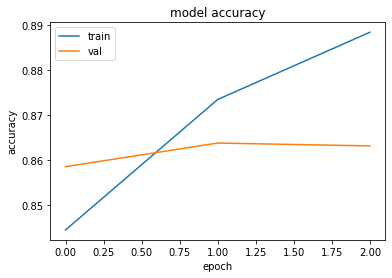

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

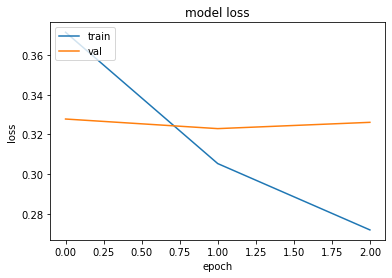

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###evaluate model

In [65]:
test_path = "/content/drive/MyDrive/DM/dev.csv"

In [66]:
test_df = pd.read_csv(test_path, delimiter='\t' , index_col=0)
test_df['clean_comment'] = test_df['comment'].apply(TextCleaner.clean_text)
test_sequences = tokenizer.texts_to_sequences(test_df.clean_comment)
test_data = pad_sequences(test_sequences, maxlen=max_len)

error
error


In [67]:
y_pred = model.predict(test_data)

In [68]:
y_pred = np.array(y_pred > 0.5).astype("int32")

In [69]:
print(classification_report(test_df.label_id, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      3150
           1       0.83      0.91      0.87      3150

    accuracy                           0.86      6300
   macro avg       0.87      0.86      0.86      6300
weighted avg       0.87      0.86      0.86      6300



In [70]:
print("precision_score", precision_score(test_df.label_id, y_pred , average="macro"))
print("recall_score", recall_score(test_df.label_id, y_pred , average="macro"))
print("f1_score", f1_score(test_df.label_id, y_pred , average="macro"))

precision_score 0.8659434182990394
recall_score 0.8631746031746032
f1_score 0.8629152992947808
